# Rozwiązanie

In [1]:
using LinearAlgebra, Statistics, DataFrames, Polynomials, Plots, CSV, TaylorSeries

## Zadanie 1 

In [2]:
# mnożenie macierzy - wersja naiwna
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

naive_multiplication (generic function with 1 method)

In [3]:
# poprawiona funkcja korzytająca z powyższego oraz z faktu, że
# można zmieniać kolejność operacji dodawania (a co za tym idzie kolejnosc petli).
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

better_multiplication (generic function with 1 method)

In [4]:
function BLAS(A, B)
    A*B
end

BLAS (generic function with 1 method)

In [5]:
df = DataFrame(Type = String[], Size = Int[], Time = Float64[])
for size = 2:50:502
    for i = 1:11
        A = rand(0:9,(size, size))
        B = rand(0:9,(size, size))
        time1 = @elapsed naive_multiplication(A, B)
        time2 = @elapsed better_multiplication(A, B)
        time3 = @elapsed BLAS(A, B)
        if i > 1
            push!(df, ("Naive", size, time1))
            push!(df, ("Better", size, time2))
            push!(df, ("BLAS", size, time3))
        end
    end
end


In [7]:
df2 = combine(groupby(df, [:Size, :Type]), :Time => mean, :Time => std)

Row,Size,Type,Time_mean,Time_std
,Int64,String,Float64,Float64
1,2,Naive,2.1e-7,3.14289e-7
2,2,Better,1.1e-7,5.67646e-8
3,2,BLAS,1.2e-7,6.32456e-8
4,52,Naive,0.00034472,5.02898e-6
5,52,Better,0.00017543,7.66725e-6
6,52,BLAS,0.00010419,1.61648e-5
7,102,Naive,0.00282806,6.05082e-5
8,102,Better,0.00123944,3.94893e-5
9,102,BLAS,0.00062496,2.01189e-5


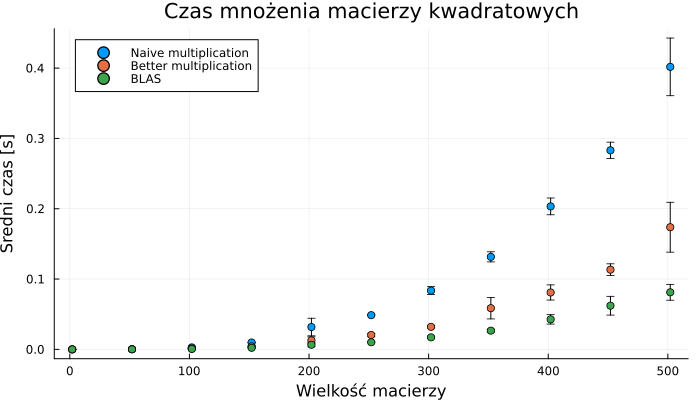

In [8]:
scatter(df2[df2[:,2] .== "Naive", :].Size,
    size = (700, 400),
    xlabel = "Wielkość macierzy",
    ylabel = "Średni czas [s]",
    label = ["Naive multiplication" "Better multiplication" "BLAS"],
    title = "Czas mnożenia macierzy kwadratowych", 
    [df2[df2[:,2] .== "Naive", :].Time_mean df2[df2[:,2] .== "Better", :].Time_mean df2[df2[:,2] .== "BLAS", :].Time_mean],
    yerr = [df2[df2[:,2] .== "Naive", :].Time_std df2[df2[:,2] .== "Better", :].Time_std df2[df2[:,2] .== "BLAS", :].Time_std])


## Zadanie 2

``` c
#include <stdio.h>
#include <gsl/gsl_blas.h>
#include <gsl/gsl_sf_bessel.h>
#include <sys/times.h>
#include <stdlib.h>
#include <unistd.h>
#include <fcntl.h>

struct tms tms_start, tms_end;
clock_t clock_start, clock_end;

void start_time() {
    clock_start = times(&tms_start);
}

void end_time() {
    clock_end = times(&tms_end);
}

double time() {
    int tics = sysconf(_SC_CLK_TCK);
    double time = (double) (clock_end - clock_start) / tics;
    return time;
}

void naive_multiplication(double **A, double **B, double **C, int size) {
    for (int i = 0; i < size; i++) {
        for (int j = 0; j < size; j++) {
            for (int k = 0; k < size; k++) {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
}

void better_multiplication(double **A, double **B, double **C, int size) {
    for (int i = 0; i < size; i++) {
        for (int k = 0; k < size; k++) {
            for (int j = 0; j < size; j++) {
                C[i][j] += A[i][k] * B[k][j];
            }
        }
    }
}

void blas_multiplication(double *a, double *b, double *c, int size) {
    gsl_matrix_view D = gsl_matrix_view_array(a, size, size);
    gsl_matrix_view E = gsl_matrix_view_array(b, size, size);
    gsl_matrix_view F = gsl_matrix_view_array(c, size, size);
    gsl_blas_dgemm(CblasNoTrans, CblasNoTrans, 1.0, &D.matrix, &E.matrix, 0.0, &F.matrix);
}

int main(int argc, char *argv[]) {
    double **A, **B, **C;
    double *a, *b, *c;
    double time1, time2, time3;
    FILE *file = fopen("times.csv", "a");
    for (int i = 2; i <= 502; i += 50) {
        A = calloc(i, sizeof(double *));
        B = calloc(i, sizeof(double *));
        C = calloc(i, sizeof(double *));
        a = calloc(i * i, sizeof(double));
        b = calloc(i * i, sizeof(double));
        c = calloc(i * i, sizeof(double));
        for (int j = 0; j < i; j++) {
            A[j] = calloc(i, sizeof(double));
            B[j] = calloc(i, sizeof(double));
            C[j] = calloc(i, sizeof(double));
        }
        for (int j = 0; j < 10; j++) {
            for (int k = 0; k < i; k++) {
                for (int a = 0; a < i; a++) {
                    A[k][a] = rand() % 10;
                    B[k][a] = rand() % 10;
                }
            }
            start_time();
            naive_multiplication(A, B, C, i);
            end_time();
            time1 = time();

            start_time();
            better_multiplication(A, B, C, i);
            end_time();
            time2 = time();

            for (int k = 0; k < i * i; k++) {
                a[k] = A[k / i][k % i];
                b[k] = B[k / i][k % i];
            }

            start_time();
            blas_multiplication(a, b, c, i);
            end_time();
            time3 = time();

            fprintf(file, "%d,%f,%f,%f\n", i, time1, time2, time3);
        }
        for (int j = 0; j < i; j++) {
            free(A[j]);
            free(B[j]);
            free(C[j]);
        }
        free(a);
        free(b);
        free(c);
        free(A);
        free(B);
        free(C);
    }
    fclose(file);
    return 0;
}
```

In [9]:
data = CSV.read("times.csv", delim =",", DataFrame)
data2 = combine(groupby(data, :Size), :Naive => mean, :Naive =>std, :Better => mean, :Better =>std, :BLAS => mean, :BLAS =>std)

Row,Size,Naive_mean,Naive_std,Better_mean,Better_std,BLAS_mean,BLAS_std
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,2,0.0,0.0,0.0,0.0,0.0,0.0
2,52,0.007,0.0105935,0.008,0.0113529,0.005,0.00849837
3,102,0.045,0.0217307,0.034,0.00699206,0.024,0.0117379
4,152,0.108,0.00788811,0.118,0.018738,0.062,0.0113529
5,202,0.264,0.0142984,0.266,0.0195505,0.162,0.0193218
6,252,0.532,0.0229976,0.501,0.0196921,0.299,0.0137032
7,302,0.91,0.0713364,0.88,0.0444722,0.532,0.0315524
8,352,1.135,0.0283823,1.035,0.0406202,0.617,0.03335
9,402,1.932,0.122819,1.6,0.0959166,0.918,0.0261619


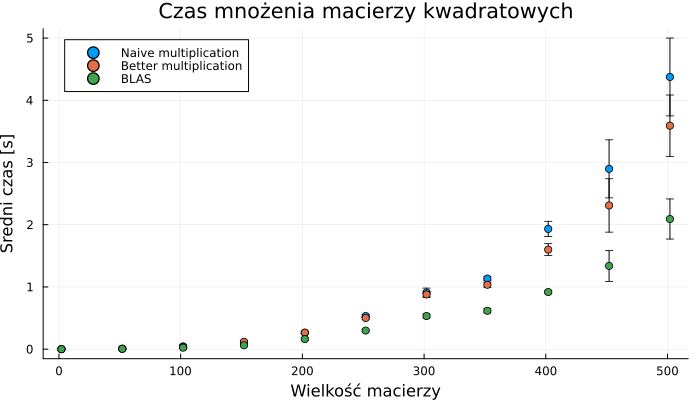

In [10]:
scatter(data2.Size,
    size = (700, 400),
    xlabel = "Wielkość macierzy",
    ylabel = "Średni czas [s]",
    label = ["Naive multiplication" "Better multiplication" "BLAS"],
    title = "Czas mnożenia macierzy kwadratowych", 
    [data2.Naive_mean data2.Better_mean data2.BLAS_mean],
    yerr = [data2.Naive_std data2.Better_std data2.BLAS_std])


## Zadanie 3

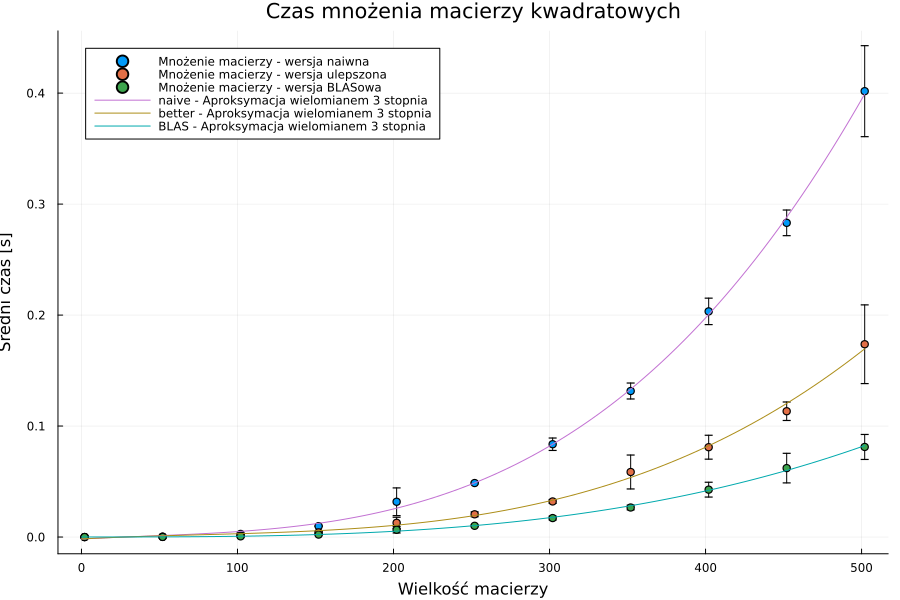

In [11]:
fit1 = fit(df2[df2[:,2] .== "Naive", :].Size, df2[df2[:,2] .== "Naive", :].Time_mean, 3)
fit2 = fit(df2[df2[:,2] .== "Better", :].Size, df2[df2[:,2] .== "Better", :].Time_mean, 3)
fit3 = fit(df2[df2[:,2] .== "BLAS", :].Size, df2[df2[:,2] .== "BLAS", :].Time_mean, 3)
xs = 0:1:502

scatter(df2[df2[:,2] .== "Naive", :].Size,
    size = (900, 600),
    xlabel = "Wielkość macierzy",
    ylabel = "Średni czas [s]",
    label = ["Mnożenie macierzy - wersja naiwna" "Mnożenie macierzy - wersja ulepszona" "Mnożenie macierzy - wersja BLASowa"],
    title = "Czas mnożenia macierzy kwadratowych", 
    [df2[df2[:,2] .== "Naive", :].Time_mean df2[df2[:,2] .== "Better", :].Time_mean df2[df2[:,2] .== "BLAS", :].Time_mean],
    yerr = [df2[df2[:,2] .== "Naive", :].Time_std df2[df2[:,2] .== "Better", :].Time_std df2[df2[:,2] .== "BLAS", :].Time_std])


plot!(fit1, extrema(xs)..., label = "naive - Aproksymacja wielomianem 3 stopnia")
plot!(fit2, extrema(xs)..., label = "better - Aproksymacja wielomianem 3 stopnia")
plot!(fit3, extrema(xs)..., label = "BLAS - Aproksymacja wielomianem 3 stopnia")


## Zadanie 4


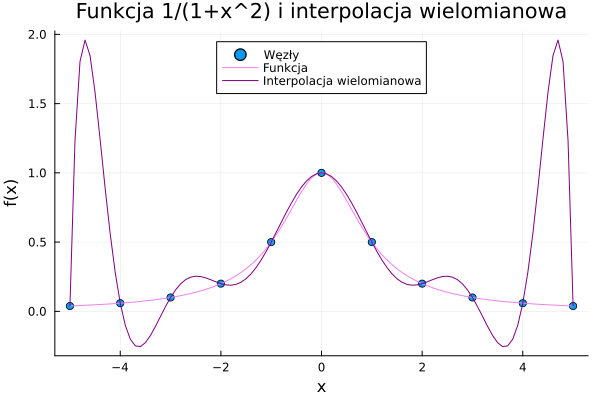

In [12]:
function f(x)
    1/(1+x^2)
end
    
xs = -5:1:5
ys = map(f, xs)
poly_aprox = fit(xs, ys, 10)

scatter(xs,
        ys,
        title = "Funkcja 1/(1+x^2) i interpolacja wielomianowa",
        xlabel = "x",
        ylabel = "f(x)",
        label = "Węzły",
        legend_position = :top)

plot!(f,
    extrema(xs)...,
    label="Funkcja",
    color = :violet)

plot!(poly_aprox,
    extrema(xs)...,
    label="Interpolacja wielomianowa",
    color = :purple)

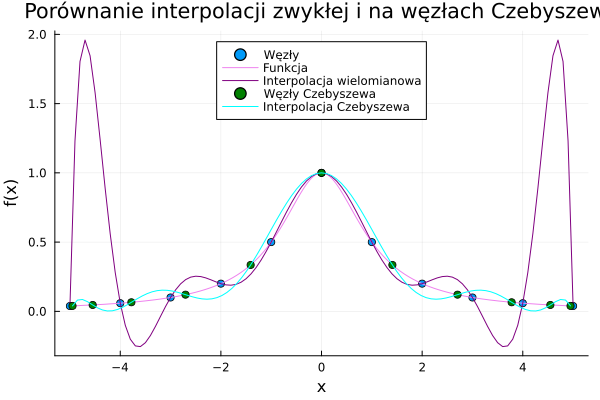

In [13]:
base = [0,0,0,0,0,0,0,0,0,0,0,1]
chebyszev = ChebyshevT(base)
che_poly_zeros  = Polynomials.roots(chebyszev)
che_poly_zeros  = 5 * che_poly_zeros 
ys2 = map(f, che_poly_zeros)
poly_approx_che = fit(che_poly_zeros, ys2, 10)
scatter!(
    che_poly_zeros, 
    ys2, 
    label = "Węzły Czebyszewa",
    color = :green, 
    title="Porównanie interpolacji zwykłej i na węzłach Czebyszewa",
)

plot!(poly_approx_che,
    extrema(che_poly_zeros)...,
    label = "Interpolacja Czebyszewa",
    color = :cyan
)

## Zadanie 5

In [14]:
t = Taylor1(Float64, 5)

 1.0 t + 𝒪(t⁶)

In [15]:
function myfun(x)
    log(1+x)/x
end

myfun (generic function with 1 method)

In [16]:
myfun_taylor = myfun(t)

 1.0 - 0.5 t + 0.3333333333333333 t² - 0.25 t³ + 0.2 t⁴ + 𝒪(t⁵)

In [17]:
myfun_taylor_pol = Polynomial(myfun_taylor.coeffs)

Polynomial(1.0 - 0.5*x + 0.3333333333333333*x^2 - 0.25*x^3 + 0.2*x^4)

In [18]:
myfun_pade = Polynomials.PolyCompat.PadeApproximation.Pade(myfun_taylor_pol, 2, 2)

Polynomials.PolyCompat.PadeApproximation.Pade{Float64, Float64}(Polynomial(1.0 + 0.6999999999999987*x + 0.03333333333333298*x^2), Polynomial(1.0 + 1.1999999999999986*x + 0.29999999999999905*x^2), :x)

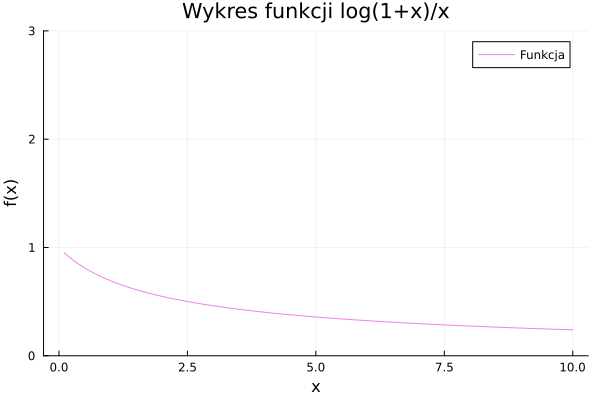

In [19]:
xsf = 0:0.1:10
y1 = [myfun(x) for x in xsf]
y2 = [myfun_taylor_pol(x) for x in xsf]
y3 = [myfun_pade(x) for x in xsf]


plot(xsf,
    y1,
    xlabel = "x",
    ylabel = "f(x)",
    ylims = [0,3],
    title = "Wykres funkcji log(1+x)/x",
    label = "Funkcja",
    color = :violet)

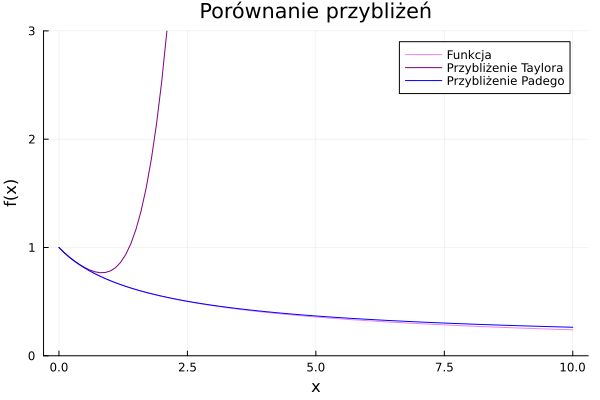

In [20]:
plot(xsf,
    [y1 y2 y3],
    xlabel = "x",
    ylabel = "f(x)",
    ylims = [0,3],
    title = "Porównanie przybliżeń",
    label = ["Funkcja" "Przybliżenie Taylora" "Przybliżenie Padego"],
    color = [:violet :purple :blue])